In [2]:
%run __init__.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from itertools import combinations
from tools import *
from before_stack import *
from conversion import *
from aper_phot import *
from cr_to_flux import *

In [11]:
def fits_sub(img_uw1_name, img_uvv_name, mon, r):
    img_uw1_data = load_img(img_uw1_name)
    img_uvv_data = load_img(img_uvv_name)
    img_uw1_header = load_header(img_uw1_name)
    exposure_uw1 = float(load_header(img_uw1_name)['EXPTIME'])
    exposure_uvv = float(load_header(img_uvv_name)['EXPTIME'])
    beta = 0.09276191501510327
    beta = reddening_correct(r)*beta
    sub_data = img_uw1_data/exposure_uw1 \
               - beta*(img_uvv_data/exposure_uvv)
    sub_data_err = img_uw1_data/np.power(exposure_uw1,2) + img_uvv_data*np.power(beta/exposure_uvv,2)
    output_path = get_path('../docs/'+mon+'_sub_red15.fits')
    output_path_err = get_path('../docs/'+mon+'_sub_red15_err.fits')
    hdu = fits.PrimaryHDU(sub_data)
    hdr = hdu.header
    hdr['TELESCOP'] = img_uw1_header['TELESCOP']
    hdr['INSTRUME'] = img_uw1_header['INSTRUME']
    hdr['COMET'] = img_uw1_header['COMET']
    hdr['XPOS'] = img_uw1_header['XPOS']
    hdr['YPOS'] = img_uw1_header['YPOS']
    hdr['MID_T_UV'] = img_uw1_header['MID_TIME']
    hdr['MID_T_V'] = load_header(img_uvv_name)['MID_TIME']
    hdu.writeto(output_path)
    hdu_err = fits.PrimaryHDU(sub_data_err)
    hdu_err.writeto(output_path_err)
    
fits_sub('sep_stack_uw1.fits', 'sep_stack_part_uvv.fits', 'sep', 15)
fits_sub('nov_stack_uw1.fits', 'nov_stack_uvv.fits', 'nov', 15)
fits_sub('dec_stack_uw1.fits', 'dec_stack_uvv.fits', 'dec', 15)

In [3]:
def q(mon, aperture, if_mask, start):
    src_r = aperture
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    spec_name_sum = 'cont_emis_sum.txt'
    src_center = (1000, 1000)
    img_name = mon+'_sub_red15.fits'
    err_name = mon+'_sub_red15_err.fits'
    bg_reg_name = mon+'_sub_bg.reg'
    mask_name = mon+'_mask.reg'
    if mon == 'sep':
        lowlim = -0.0015
        uplim = 0.0015
        if start:
            start = 5
    elif mon == 'nov':
        lowlim = -0.002
        uplim = 0.002
        if start:
            start = 15
    elif mon == 'dec':
        lowlim = -0.001
        uplim = 0.002
        if start:
            start = 15
    else:
        pass
    if if_mask == 'limit':
        mask_img = mask(img_name, lowlim, uplim)
    elif if_mask == 'region':
        mask_img = mask_region(img_name, mask_name)
    elif if_mask == 'both':
        mask_img = mask(img_name, lowlim, uplim)
        mask_img = mask_region(mask_img, mask_name)
    else:
        mask_img = False
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))
    if if_mask == 'no':
        src_method = 'total_median'
    else:
        src_method = 'azim_median'
    result = aper_phot(img_name, False, 
                       src_center, src_r,
                       bg_center, bg_r,
                       src_method, 
                       'multi_mean',
                       int(aperture/5.), 
                       mask_img, start)
    cr = result[0][0]
    cr_err, pixel = circle_ct(err_name, src_center, src_r, 'mean', mask_img)
    pixel_unmask = circle_ct(err_name, src_center, src_r, 'median', mask_img)[1]
    cr_err = (np.sqrt(cr_err)*1.253/pixel)*pixel_unmask
    
    flux = 1.2750906353215913e-12*cr
    flux_err = 1.2750906353215913e-12*cr_err
    
    obs_log_name = mon+'_obs-log_Borisov.txt'
    wvm_name = mon+'_wvm.txt'
    
    num, num_err = flux2num(flux, flux_err, 
                            'fluorescenceOH.txt',
                            obs_log_name,
                            method='both_ends',
                            horizon_id=90004424,
                            if_show=False)
    
    q, q_err = num2q(num, num_err,
                     wvm_name, aperture,
                     if_show=False)
    return q, q_err

def q_aper(mon, aperture_list, if_mask, start):
    q_list = []
    q_err_list = []
    for aperture in aperture_list:
        q_i, q_err_i = q(mon, aperture, if_mask, start)
        q_list.append(q_i)
        q_err_list.append(q_err_i)
    return q_list, q_err_list

def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(6, 15, 1)
        aper2 = np.arange(15, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(6, 50, 1)
        aper2 = np.arange(50, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(6, 40, 1)
        aper2 = np.arange(40, 205, 5)
        return np.concatenate((aper1, aper2))

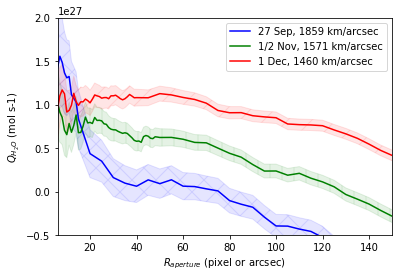

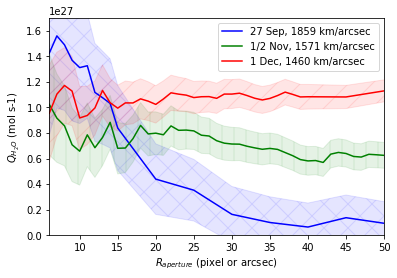

In [4]:

sep_aper_list = np.array(mon2aper_list('sep'))
#sep_q_unmask, sep_q_err_unmask = q_aper('sep', sep_aper_list, 'no', False)
sep_q_region, sep_q_err_region = q_aper('sep', sep_aper_list, 'region', False)
sep_q_region = np.array(sep_q_region)
sep_q_err_region = np.array(sep_q_err_region)
#sep_q_unmask = np.array(sep_q_unmask)
#sep_q_err_unmask = np.array(sep_q_err_unmask)

nov_aper_list = np.array(mon2aper_list('nov'))
#nov_q_unmask, nov_q_err_unmask = q_aper('nov', nov_aper_list, 'no', False)
nov_q_region, nov_q_err_region = q_aper('nov', nov_aper_list, 'region', False)
nov_q_region = np.array(nov_q_region)
nov_q_err_region = np.array(nov_q_err_region)
#nov_q_unmask = np.array(nov_q_unmask)
#nov_q_err_unmask = np.array(nov_q_err_unmask)

dec_aper_list = np.array(mon2aper_list('dec'))
#dec_q_unmask, dec_q_err_unmask = q_aper('dec', mon2aper_list('dec'), 'no', False)
dec_q_region, dec_q_err_region = q_aper('dec', dec_aper_list, 'region', False)
dec_q_region = np.array(dec_q_region)
dec_q_err_region = np.array(dec_q_err_region)
#dec_q_unmask = np.array(dec_q_unmask)
#dec_q_err_unmask = np.array(dec_q_err_unmask)

fig1 = plt.figure()
fig1.add_subplot(111)

#plt.plot(sep_aper_list, sep_q_unmask, 'b--', label='27 Sep, 1859 km/arcsec')
plt.plot(sep_aper_list, sep_q_region, 'b', label='27 Sep, 1859 km/arcsec')
plt.fill_between(sep_aper_list, sep_q_region-sep_q_err_region, sep_q_region+sep_q_err_region, color='b',alpha=0.1, hatch='x')

#plt.plot(nov_aper_list, nov_q_unmask, 'g--', label='1/2 Nov, 1571 km/arcsec')
plt.plot(nov_aper_list, nov_q_region, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.fill_between(nov_aper_list, nov_q_region-nov_q_err_region, nov_q_region+nov_q_err_region, color='g',alpha=0.1, hatch='|')

#plt.plot(dec_aper_list, dec_q_unmask, 'r--', label='1 Dec, 1460 km/arcsec')
plt.plot(dec_aper_list, dec_q_region, 'r', label='1 Dec, 1460 km/arcsec')
plt.fill_between(dec_aper_list, dec_q_region-dec_q_err_region, dec_q_region+dec_q_err_region, color='r',alpha=0.1, hatch='/')

plt.legend()
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')
plt.ylim(-0.5e27,2e27)
plt.xlim(6,150)

fig2 = plt.figure()
fig2.add_subplot(111)
#plt.plot(sep_aper_list, sep_q_unmask, 'b', label='27 Sep, 1859 km/arcsec')
plt.plot(sep_aper_list, sep_q_region, 'b', label='27 Sep, 1859 km/arcsec')
plt.fill_between(sep_aper_list, sep_q_region-sep_q_err_region, sep_q_region+sep_q_err_region, color='b',alpha=0.1, hatch='x')
#plt.plot(nov_aper_list, nov_q_unmask, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.plot(nov_aper_list, nov_q_region, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.fill_between(nov_aper_list, nov_q_region-nov_q_err_region, nov_q_region+nov_q_err_region, color='g',alpha=0.1, hatch='|')
#plt.plot(dec_aper_list, dec_q_unmask, 'r', label='1 Dec, 1460 km/arcsec')
plt.plot(dec_aper_list, dec_q_region, 'r', label='1 Dec, 1460 km/arcsec')
plt.fill_between(dec_aper_list, dec_q_region-dec_q_err_region, dec_q_region+dec_q_err_region, color='r',alpha=0.1, hatch='/')
plt.legend()
plt.xlim(6,50)
plt.ylim(6,1.7e27)
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')

plt.show()

In [8]:
def q(mon, aperture, if_mask, start):
    src_r = aperture
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    spec_name_sum = 'cont_emis_sum.txt'
    src_center = (1000, 1000)
    img_name = mon+'_sub.fits'
    bg_reg_name = mon+'_sub_bg.reg'
    mask_name = mon+'_mask.reg'
    if mon == 'sep':
        lowlim = -0.0015
        uplim = 0.0015
        if start:
            start = 5
    elif mon == 'nov':
        lowlim = -0.002
        uplim = 0.002
        if start:
            start = 10
    elif mon == 'dec':
        lowlim = -0.001
        uplim = 0.002
        if start:
            start = 15
    else:
        pass
    if if_mask == 'limit':
        mask_img = mask(img_name, lowlim, uplim)
    elif if_mask == 'region':
        mask_img = mask_region(img_name, mask_name)
    elif if_mask == 'both':
        mask_img = mask(img_name, lowlim, uplim)
        mask_img = mask_region(mask_img, mask_name)
    else:
        mask_img = False
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))
    if if_mask == 'no':
        src_method = 'total_mean'
    else:
        src_method = 'azim_median'
    result = aper_phot(img_name, False, 
                       src_center, src_r,
                       bg_center, bg_r,
                       src_method, 
                       'multi_mean',
                       int(aperture/5.), 
                       mask_img, start)
    cr, cr_err = result[0]
    
    flux = 1.2750906353215913e-12*cr
    flux_err = 1.2750906353215913e-12*cr_err
    
    obs_log_name = mon+'_obs-log_Borisov.txt'
    wvm_name = mon+'_wvm.txt'
    
    num, num_err = flux2num(flux, flux_err, 
                            'fluorescenceOH.txt',
                            obs_log_name,
                            method='both_ends',
                            horizon_id=90004424,
                            if_show=False)
    
    q, q_err = num2q(num, num_err,
                     wvm_name, aperture,
                     False, start)
    return q, q_err

def q_aper(mon, aperture_list, if_mask, start):
    q_list = []
    q_err_list = []
    for aperture in aperture_list:
        q_i, q_err_i = q(mon, aperture, if_mask, start)
        q_list.append(q_i)
        q_err_list.append(q_err_i)
    return q_list, q_err_list

def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(10, 15, 1)
        aper2 = np.arange(15, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(15, 50, 1)
        aper2 = np.arange(50, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(20, 40, 1)
        aper2 = np.arange(40, 205, 5)
        return np.concatenate((aper1, aper2))

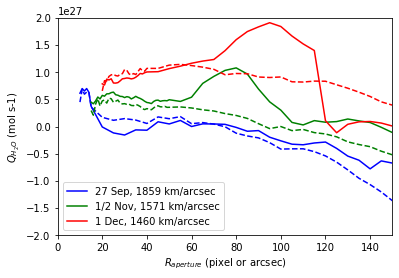

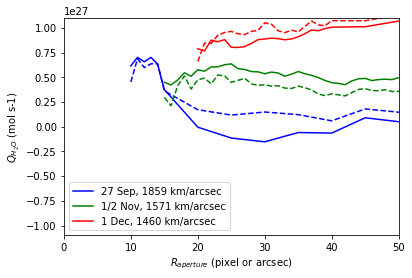

In [9]:

sep_aper_list = mon2aper_list('sep')
sep_q_unmask, sep_q_err_unmask = q_aper('sep', sep_aper_list, 'no', True)
sep_q_region, sep_q_err_region = q_aper('sep', sep_aper_list, 'region', True)
sep_aper_list = np.array(sep_aper_list)
sep_q_unmask = np.array(sep_q_unmask)
sep_q_err_unmask = np.array(sep_q_err_unmask)

nov_aper_list = mon2aper_list('nov')
nov_q_unmask, nov_q_err_unmask = q_aper('nov', nov_aper_list, 'no', True)
nov_q_region, nov_q_err_region = q_aper('nov', nov_aper_list, 'region', True)
nov_aper_list = np.array(nov_aper_list)
nov_q_unmask = np.array(nov_q_unmask)
nov_q_err_unmask = np.array(nov_q_err_unmask)

dec_aper_list = mon2aper_list('dec')
dec_q_unmask, dec_q_err_unmask = q_aper('dec', dec_aper_list, 'no', True)
dec_q_region, dec_q_err_region = q_aper('dec', dec_aper_list, 'region', True)
dec_aper_list = np.array(dec_aper_list)
dec_q_unmask = np.array(dec_q_unmask)
dec_q_err_unmask = np.array(dec_q_err_unmask)

fig1 = plt.figure()
fig1.add_subplot(111)

plt.plot(sep_aper_list, sep_q_unmask, 'b', label='27 Sep, 1859 km/arcsec')
plt.plot(sep_aper_list, sep_q_region, 'b--')
#plt.fill_between(sep_aper_list, sep_q_list-sep_q_err_list, sep_q_list+sep_q_err_list, color='b',alpha=0.1)

plt.plot(nov_aper_list, nov_q_unmask, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.plot(nov_aper_list, nov_q_region, 'g--')
#plt.fill_between(nov_aper_list, nov_q_list-nov_q_err_list, nov_q_list+nov_q_err_list, color='g',alpha=0.1)

plt.plot(dec_aper_list, dec_q_unmask, 'r', label='1 Dec, 1460 km/arcsec')
plt.plot(dec_aper_list, dec_q_region, 'r--')
#plt.fill_between(dec_aper_list, dec_q_list-dec_q_err_list, dec_q_list+dec_q_err_list, color='r',alpha=0.1)

plt.legend()
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')
plt.ylim(-2e27,2e27)
plt.xlim(0,150)

fig2 = plt.figure()
fig2.add_subplot(111)
plt.plot(sep_aper_list, sep_q_unmask, 'b', label='27 Sep, 1859 km/arcsec')
plt.plot(sep_aper_list, sep_q_region, 'b--')
#plt.fill_between(sep_aper_list, sep_q_list-sep_q_err_list, sep_q_list+sep_q_err_list, color='b',alpha=0.1)
plt.plot(nov_aper_list, nov_q_unmask, 'g', label='1/2 Nov, 1571 km/arcsec')
plt.plot(nov_aper_list, nov_q_region, 'g--')
#plt.fill_between(nov_aper_list, nov_q_list-nov_q_err_list, nov_q_list+nov_q_err_list, color='g',alpha=0.1)
plt.plot(dec_aper_list, dec_q_unmask, 'r', label='1 Dec, 1460 km/arcsec')
plt.plot(dec_aper_list, dec_q_region, 'r--')
#plt.fill_between(dec_aper_list, dec_q_list-dec_q_err_list, dec_q_list+dec_q_err_list, color='r',alpha=0.1)
plt.legend()
plt.xlim(0,50)
plt.ylim(-1.1e27,1.1e27)
plt.xlabel(r'$R_{aperture}$ (pixel or arcsec)')
plt.ylabel(r'$Q_{H_2O}$ (mol s-1)')

plt.show()

In [12]:
print(dec_aper_list, dec_q_region)

[ 20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  45  50  55  60  65  70  75  80  85  90  95 100 105 110 115
 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200] [6.581710600180273e+26, 8.458093298003299e+26, 8.429497795587219e+26, 9.249626913666149e+26, 9.52906094719903e+26, 9.642411481270779e+26, 9.398512838499815e+26, 9.316566786105632e+26, 9.635010373711219e+26, 9.750643258683205e+26, 1.0508137783203563e+27, 1.0361153078129531e+27, 9.708379982164138e+26, 9.506749313506748e+26, 9.767287534796257e+26, 9.589756448626005e+26, 1.0144857490409818e+27, 1.0693523723777303e+27, 1.0300960859726079e+27, 1.0210459134007783e+27, 1.0725748245361764e+27, 1.0720737053372344e+27, 1.1323469156214043e+27, 1.1460649172049868e+27, 1.1242289789290573e+27, 1.0951574546320566e+27, 1.0550961895024682e+27, 9.552787039871052e+26, 9.785463645453661e+26, 9.7395873150792e+26, 9.136770328465289e+26, 9.046829496801384e+26, 9.146332010510435e+26, 8.255691827382

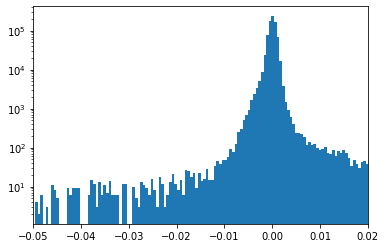

In [26]:
def cr_list_in_aper(img_name, 
                    src_center, src_r,
                    bg_center, bg_r,
                    bg_method):
    # bri of bg
    bg_shape = bg_method.split('_')[0]
    bg_stat = bg_method.split('_')[1]
    bg_bri, bg_bri_err = reg2bg_bri(img_name, bg_shape, bg_center, bg_r, bg_stat, False)
    # loop
    img_data, cen_pix, i_range, j_range = limit_loop(img_name, src_center, src_r)
    for i in i_range:
        for j in j_range:
            pos_pix = [i, j]
            pos_cen_dist = get_dist(cen_pix, pos_pix)
            if pos_cen_dist < src_r:
                cr_list.append(img_data[i, j])
    return cr_list

mon = 'dec'
img_name = mon+'_sub.fits'
src_center = (1000,1000)
src_r = 150
bg_reg_name = mon+'_sub_bg.reg'
bg = load_reg_list(bg_reg_name)
bg_x = bg[1]
bg_y = bg[0]
bg_r = bg[2]
bg_center = list(zip(bg_x, bg_y))
cr_list = cr_list_in_aper(img_name,
                          src_center, src_r,
                          bg_center, bg_r,
                          'multi_mean')
plt.hist(cr_list, bins=2000)
plt.xlim(-0.05, 0.02)
plt.yscale('log')
plt.show()

In [10]:
# generate mask.fits
'''
mon = 'dec'
src_center = (1000, 1000)
img_name = mon+'_sub.fits'
if mon == 'sep':
    lowlim = -0.0015
    uplim = 0.0015
elif mon == 'nov':
    lowlim = -0.002
    uplim = 0.002
elif mon == 'dec':
    lowlim = -0.001
    uplim = 0.002
else:
    pass
mask_img = mask(img_name, lowlim, uplim)
img_data = load_img(img_name)
output_path = get_path('../docs/'+mon+'_mask.fits')
hdu = fits.PrimaryHDU(img_data*mask_img)
hdu.writeto(output_path)
'''

In [16]:
def colden_per_pixel(mon, aperture, step, if_mask):
    src_r = aperture
    spec_name_sun = 'sun_1A.txt'
    spec_name_OH = '2019-07-15_emission_models_OH.txt'
    spec_name_sum = 'cont_emis_sum.txt'
    src_center = (1000, 1000)
    img_name = mon+'_sub.fits'
    bg_reg_name = mon+'_sub_bg.reg'
    mask_name = mon+'_mask.reg'
    if mon == 'sep':
        lowlim = -0.0015
        uplim = 0.0015
        cm_per_pixel = 2246.855143970469*1e5
    elif mon == 'nov':
        lowlim = -0.002
        uplim = 0.002
        cm_per_pixel = 1751.8686134578797*1e5
    elif mon == 'dec':
        lowlim = -0.001
        uplim = 0.002
        cm_per_pixel = 1482.6604126317716*1e5
    else:
        pass

    if if_mask == 'limit':
        mask_img = mask(img_name, lowlim, uplim)
    elif if_mask == 'region':
        mask_img = mask_region(img_name, mask_name)
    elif if_mask == 'both':
        mask_img = mask(img_name, lowlim, uplim)
        mask_img = mask_region(mask_img, mask_name)
    else:
        mask_img = False
    bg = load_reg_list(bg_reg_name)
    bg_x = bg[1]
    bg_y = bg[0]
    bg_r = bg[2]
    bg_center = list(zip(bg_x, bg_y))
    rou = []
    cts_per_pixel = []
    step_num = int(aperture/step)
    
    for i in range(0, step_num):
        r_i = (i*step,(i+1)*step)
        count_i, pixel_i = donut_ct(img_name, 
                                    src_center, 
                                    r_i,
                                    'median', 
                                    mask_img)
        rou.append((i+0.5)*step)
        cts_per_pixel.append(count_i/pixel_i)
    rou = np.array(rou)
    rou = rou*cm_per_pixel/1e5
    # cts per pixel
    colden_list = np.array(cts_per_pixel)
    # remove bkg
    bg_bri, bg_bri_err = reg2bg_bri(img_name, 'multi', bg_center, bg_r, 'mean', False)
    colden_list = colden_list - bg_bri
    colden_list = 1.2750906353215913e-12*colden_list
    obs_log_name = mon+'_obs-log_Borisov.txt'
    wvm_name = mon+'_wvm.txt'
    # num per pixel
    for i in range(len(colden_list)):
        num, num_err = flux2num(colden_list[i], 0., 
                                'fluorescenceOH.txt',
                                obs_log_name,
                                method='both_ends',
                                horizon_id=90004424,
                                if_show=False)
        colden_list[i] = num/np.power(cm_per_pixel,2)
    return rou, colden_list

def read_wvm(mon, start):
    if mon == 'sep':
        if start == True:
            q_calc = 1.717975799912132e+26
        else:
            q_calc = 1.14e+25
    elif mon == 'nov':
        if start == True:
            q_calc = 3.5654696089784575e+26
        else:
            q_calc = 4.16e+26
    elif mon == 'dec':
        if start == True:
            q_calc = 9.785463645453661e+26
        else:
            q_calc = 8.27e+26
    else:
        pass
    rou = []
    colden = []
    wvm_name = mon+'_wvm.txt'
    wvm_path = get_path('../docs/'+wvm_name)
    wvm_file = open(wvm_path)
    wvm_file_lines = wvm_file.readlines()
    wvm_file.close()
    for line in wvm_file_lines[52:70]:
        line = line[:-1]
        line = line.split()
        line = [float(i) for i in line]
        rou.append(line[0])
        rou.append(line[2])
        rou.append(line[4])
        rou.append(line[6])
        colden.append(line[1])
        colden.append(line[3])
        colden.append(line[5])
        colden.append(line[7])
    rou = np.array(rou)
    colden = np.array(colden)
    q_model = wvm_file_lines[6].split()
    q_model = float(q_model[4])
    colden = (q_calc/q_model)*colden
    return rou, colden

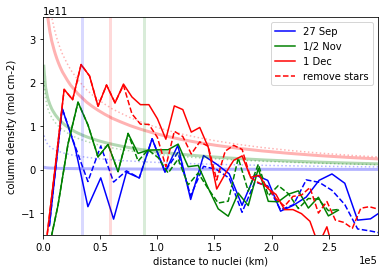

In [36]:
'''
sep_rou, sep_colden_unmask = colden_per_pixel('sep', 150, 5., 'no')
sep_colden_limit = colden_per_pixel('sep', 150, 5., 'limit')[1]
sep_colden_region = colden_per_pixel('sep', 150, 5., 'region')[1]
sep_colden_both = colden_per_pixel('sep', 150, 5., 'both')[1]
sep_rou_model, sep_colden_model = read_wvm('sep', False)
sep_rou_model_start, sep_colden_model_start = read_wvm('sep', True)
nov_rou, nov_colden_unmask = colden_per_pixel('nov', 150, 5., 'no')
nov_colden_limit = colden_per_pixel('nov', 150, 5., 'limit')[1]
nov_colden_region = colden_per_pixel('nov', 150, 5., 'region')[1]
nov_colden_both = colden_per_pixel('nov', 150, 5., 'both')[1]
nov_rou_model, nov_colden_model = read_wvm('nov', False)
nov_rou_model_start, nov_colden_model_start = read_wvm('nov', True)

dec_rou, dec_colden_unmask = colden_per_pixel('dec', 200, 5., 'no')
dec_colden_limit = colden_per_pixel('dec', 200, 5., 'limit')[1]
dec_colden_region = colden_per_pixel('dec', 200, 5., 'region')[1]
dec_colden_both = colden_per_pixel('dec', 200, 5., 'both')[1]
dec_rou_model, dec_colden_model = read_wvm('dec', False)
dec_rou_model_start, dec_colden_model_start = read_wvm('dec', True)
'''
fig, ax = plt.subplots(1,1)
plt.plot(sep_rou, sep_colden_unmask, 'b',label='27 Sep')
#plt.plot(sep_rou, sep_colden_limit, 'b:')
plt.plot(sep_rou, sep_colden_region, 'b--')
#plt.plot(sep_rou, sep_colden_both, 'b-.')
plt.plot(sep_rou_model, sep_colden_model, 'b', linewidth=3,alpha = 0.3)
plt.plot(sep_rou_model_start, sep_colden_model_start, 'b:', alpha = 0.3)

plt.plot(nov_rou, nov_colden_unmask, 'g',label='1/2 Nov')
#plt.plot(nov_rou, nov_colden_limit, 'g:')
plt.plot(nov_rou, nov_colden_region, 'g--')
#plt.plot(nov_rou, nov_colden_both, 'g-.')
plt.plot(nov_rou_model, nov_colden_model, 'g', linewidth=3,alpha = 0.3)
plt.plot(nov_rou_model_start, nov_colden_model_start, 'g:', alpha = 0.3)

plt.plot(dec_rou, dec_colden_unmask, 'r',label='1 Dec')
#plt.plot(dec_rou, dec_colden_limit, 'r:')
plt.plot(dec_rou, dec_colden_region, 'r--', label='remove stars')
#plt.plot(dec_rou, dec_colden_both, 'r-.')
plt.plot(dec_rou_model, dec_colden_model, 'r', linewidth=3,alpha = 0.3)
plt.plot(dec_rou_model_start, dec_colden_model_start, 'r:', alpha = 0.3)

plt.xlim(0, dec_rou[-1])
#plt.ylim(-0.0002, 0.0002)
plt.ylim(-1.5e11, 3.5e11)

plt.plot((8.8e4,8.8e4),plt.ylim(),'g',linewidth=3,alpha=0.15)
plt.plot((3.4e4,3.4e4),plt.ylim(),'b',linewidth=3,alpha=0.15)
plt.plot((5.9e4,5.9e4),plt.ylim(),'r',linewidth=3,alpha=0.15)

sep_start = au2km(as2au(5, 3.0980))
sep_end = au2km(as2au(20, 3.0980))
nov_start = au2km(as2au(10, 2.4155))
nov_end = au2km(as2au(50, 2.4155))
dec_start = au2km(as2au(15, 2.0443))
dec_end = au2km(as2au(80, 2.0443))
'''
plt.fill((sep_start,sep_start,sep_end,sep_end),plt.ylim()+plt.ylim()[::-1],hatch='x',fill=False, edgecolor='b',alpha=0.15)
plt.fill((nov_start,nov_start,nov_end,nov_end),plt.ylim()+plt.ylim()[::-1],hatch='-',fill=False, edgecolor='g',alpha=0.15)
plt.fill((dec_start,dec_start,dec_end,dec_end),plt.ylim()+plt.ylim()[::-1],hatch='/',fill=False, edgecolor='r',alpha=0.15)
'''
#plt.xlabel('distance to nuclei (pixel)')
#plt.ylabel('median count rate (cts s-1 pixel-1)')
plt.xlabel('distance to nuclei (km)')
plt.ylabel('column density (mol cm-2)')
ax.xaxis.get_major_formatter().set_powerlimits((0,1))
plt.legend()
plt.show()


In [87]:
def perc_aper(mon, aperture, r):
    src_r = aperture
    src_center = (1000, 1000)
    if mon == 'sep':
        img_name_uw1 = 'sep_stack_uw1.fits'
        img_name_v = 'sep_stack_part_uvv.fits'
        bg_reg_name_uw1 = 'sep_bg_uw1_new.reg'
        bg_reg_name_v = 'sep_bg_uvv_new.reg'
    if mon == 'nov':
        img_name_uw1 = 'nov_stack_uw1.fits'
        img_name_v = 'nov_stack_uvv.fits'
        bg_reg_name_uw1 = 'nov_bg_uw1_new.reg'
        bg_reg_name_v = 'nov_bg_uvv_new.reg'
    if mon == 'dec':
        img_name_uw1 = 'dec_stack_uw1.fits'
        img_name_v = 'dec_stack_uvv.fits'
        bg_reg_name_uw1 = 'dec_bg_uw1_new.reg'
        bg_reg_name_v = 'dec_bg_uvv_new.reg'
    bg_uw1 = load_reg_list(bg_reg_name_uw1)
    bg_x_uw1 = bg_uw1[1]
    bg_y_uw1 = bg_uw1[0]
    bg_r_uw1 = bg_uw1[2]
    bg_center_uw1 = list(zip(bg_x_uw1, bg_y_uw1))
    bg_v = load_reg_list(bg_reg_name_v)
    bg_x_v = bg_v[1]
    bg_y_v = bg_v[0]
    bg_r_v = bg_v[2]
    bg_center_v = list(zip(bg_x_v, bg_y_v))
    mask_name = mon+'_mask.reg'
    mask_img = mask_region(img_name_uw1, mask_name)
    result_uw1 = aper_phot(img_name_uw1, 'uw1', 
                           src_center, src_r,
                           bg_center_uw1, bg_r_uw1,
                           'azim_mean','multi_mean',
                           5, mask_img, False)
    result_v = aper_phot(img_name_v, 'v', 
                           src_center, src_r,
                           bg_center_v, bg_r_v,
                           'azim_mean','multi_mean',
                           5, mask_img, False)
    cr_uw1, cr_uw1_err = result_uw1[0]
    cr_v, cr_v_err = result_v[0]
    beta = 0.09276191501510327
    beta = reddening_correct(r)*beta
    return ((cr_uw1 - beta*cr_v)/cr_uw1)*100

def mon2aper_list(mon):
    if mon == 'sep':
        aper1 = np.arange(6, 15, 1)
        aper2 = np.arange(15, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'nov':
        aper1 = np.arange(6, 50, 1)
        aper2 = np.arange(50, 155, 5)
        return np.concatenate((aper1, aper2))
    elif mon == 'dec':
        aper1 = np.arange(6, 40, 1)
        aper2 = np.arange(40, 205, 5)
        return np.concatenate((aper1, aper2))
    
def perc_aper_l(mon, r):
    aperture_list = mon2aper_list(mon)
    perc_aper_list = []
    for aperture in aperture_list:
        perc_aper_i = perc_aper(mon, aperture, r)
        perc_aper_list.append(perc_aper_i)
    return aperture_list, perc_aper_list


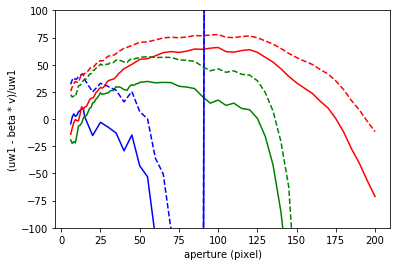

In [90]:
'''
aper_sep, perc_sep = perc_aper_l('sep', 0)
aper_nov, perc_nov = perc_aper_l('nov', 0)
aper_dec, perc_dec = perc_aper_l('dec', 0)
aper_sep, perc_sep_r = perc_aper_l('sep', 15)
aper_nov, perc_nov_r = perc_aper_l('nov', 15)
aper_dec, perc_dec_r = perc_aper_l('dec', 15)
'''
plt.plot(aper_sep, perc_sep, 'b')
plt.plot(aper_nov, perc_nov, 'g')
plt.plot(aper_dec, perc_dec, 'r')
plt.plot(aper_sep, perc_sep_r, 'b--')
plt.plot(aper_nov, perc_nov_r, 'g--')
plt.plot(aper_dec, perc_dec_r, 'r--')
plt.xlabel('aperture (pixel)')
plt.ylabel('(uw1 - beta * v)/uw1')
plt.ylim(-100,100)
plt.show()